# Machine Learning - Homework 9

## Apply a GRU architecture for a different stock symbol

In [ ]:
%pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.6 M

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras import layers
import os
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
stock_df = pd.read_csv('./AllData25sym2019.txt', delimiter='\t')

stock_df.set_index('Date', inplace=True, drop=False)

symbol = 'OIL'
days_back_nr = 30
train_percent = 70
only_load_model = False

brd_df = stock_df.loc[stock_df['Symbol'] == symbol]

rows_nr = len(brd_df)
train_nr = int((train_percent / 100) * rows_nr)
training_data = brd_df[:train_nr]
training_processed = training_data[['ClosePrice']].values

scaler = MinMaxScaler()
training_scaled = scaler.fit_transform(training_processed)

features = []
labels = []

for i in range(days_back_nr, len(training_processed)):
  features.append(training_scaled[i - days_back_nr:i, 0])
  labels.append(training_scaled[i, 0])

features_set = np.array(features)
labels = np.array(labels)

features_set = np.reshape(
    features_set,
    (features_set.shape[0], features_set.shape[1], 1)
)

In [ ]:
test_data = brd_df[(train_nr + 1):]
test_processed = test_data[['ClosePrice']].values

test_dates = test_data[['Date']].values
test_dates = [only_date for [only_date] in test_dates]

total = pd.concat((training_data['ClosePrice'], test_data['ClosePrice']), axis=0)
test_inputs = total[len(total) - len(test_processed) - days_back_nr:].values
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)

test_features = []

for i in range(days_back_nr, len(test_processed) + days_back_nr):
  test_features.append(test_inputs[i - days_back_nr:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(
    test_features,
    (test_features.shape[0], test_features.shape[1], 1)
)

In [ ]:
model = Sequential()

model.add(layers.GRU(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

fileModelName = f"GRUmodel{symbol}DaysBack{days_back_nr}.h5"

if only_load_model == False or not os.path.isfile(fileModelName):
  model.fit(features_set, labels, epochs=2, batch_size=32)
  model.save_weights(fileModelName)
else:
  model.load_weights(fileModelName)

  print('No training is done, the model is loaded from', fileModelName)
  print('If training is desired, set onlyLoadModel variable to False. ')

predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

Epoch 1/2
103/103 [==============================] - 13s 9ms/step - loss: 0.0036
Epoch 2/2
45/45 [==============================] - 1s 4ms/step


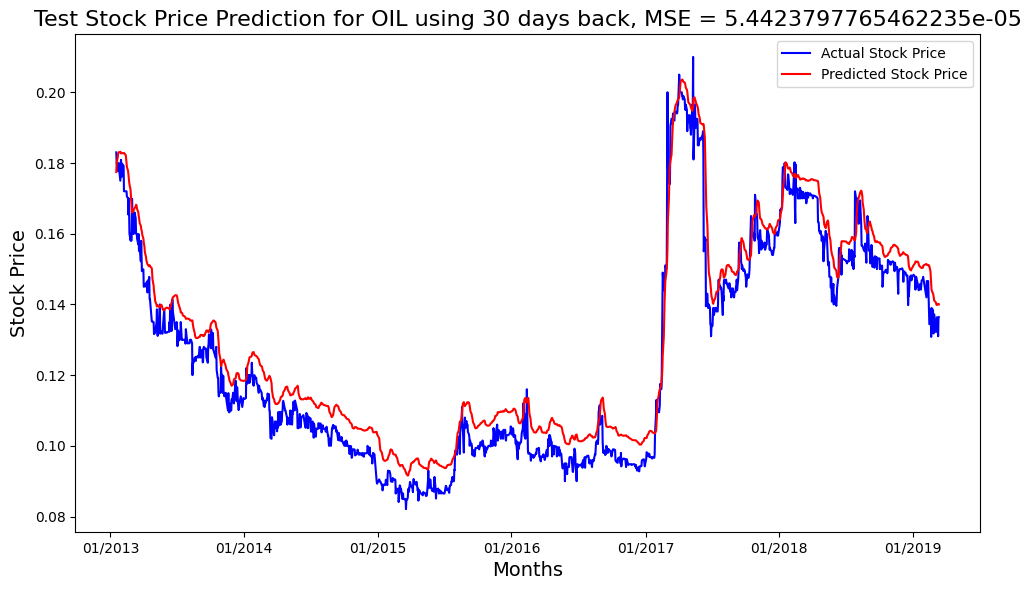

In [ ]:
x = [datetime.strptime(d, '%m/%d/%Y').date() for d in test_dates]
fig = plt.figure(figsize=(10,6))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.plot(x, test_processed, color='blue', label='Actual Stock Price')
plt.plot(x, predictions, color='red', label='Predicted Stock Price')
plt.title(f"Test Stock Price Prediction for {symbol} using {days_back_nr} days back, MSE = {mean_squared_error(test_processed, predictions)}", fontsize=16)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Take another simple transformer model from https://simpletransformers.ai/docs/installation/ and train a model for a different task than sentiment analysis

The following dataset was taken from: https://www.kaggle.com/datasets/amananandrai/clickbait-dataset.

In [ ]:
clickbait_df = pd.read_csv('./clickbait_data.csv')
X = clickbait_df['headline']
y = clickbait_df['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y)

train_data = pd.DataFrame({'text': X_train, 'labels': y_train})

model_args = ClassificationArgs(num_train_epochs=1)

# Make sure you have CUDA or set 'use_cuda' to False (use_cuda=False)
model = ClassificationModel(
    "roberta",
    "roberta-base",
    args=model_args
)

model.train_model(train_data)

eval_data = pd.DataFrame({'text': X_test, 'labels': y_test})
result, model_outputs, wrong_predictions = model.eval_model(eval_data)

print("Results: ", result)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

Results:  {'mcc': 0.9867969656551121, 'tp': 3991, 'tn': 3956, 'fp': 7, 'fn': 46, 'auroc': 0.999903429237164, 'auprc': 0.9999049653640694, 'eval_loss': 0.022916315451264383}
